# Neural Networks as Function Approximators

## Introduction

Having established the 1D Poisson equation as our benchmark problem, we now take the crucial step from mathematical theory to computational practice. The central question driving this exploration is: *How can we train a neural network to approximate an unknown function from sparse data?*

This notebook introduces the fundamental concepts of neural network function approximation. We transform the abstract notion of "learning a function" into concrete algorithms, revealing both the power and initial limitations of simple network architectures.

## Mathematical Framework

Consider a target function $u^*(x)$ that we wish to approximate. In our case, this is the solution to the 1D Poisson equation:
$$u^*(x) = \sin(\pi x)$$

We represent our neural network approximation as:
$$u_{NN}(x; \theta) = f_{\theta}(x)$$

where $\theta$ represents all trainable parameters (weights and biases). The goal is to find parameters $\theta^*$ such that:
$$u_{NN}(x; \theta^*) \approx u^*(x) \quad \forall x \in [0,1]$$

We achieve this by minimizing a loss function over a training dataset $\{(x_i, u_i)\}_{i=1}^N$:
$$\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N \left(u_{NN}(x_i; \theta) - u_i\right)^2$$

This framework transforms function approximation into an optimization problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.patches import FancyBboxPatch

# Set up reproducibility and plotting
torch.manual_seed(42)
np.random.seed(42)

plt.style.use('default')
plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (12, 8),
    'lines.linewidth': 2.5,
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Define the target function
def target_function(x):
    """Target function: u(x) = sin(π*x)"""
    return np.sin(np.pi * x)

# Generate training data
n_train = 15
x_train = np.linspace(0, 1, n_train)
u_train = target_function(x_train)

# Add small amount of noise for realism
noise_level = 0.01
u_train_noisy = u_train + noise_level * np.random.randn(n_train)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train.reshape(-1, 1), dtype=torch.float32)
u_train_tensor = torch.tensor(u_train_noisy.reshape(-1, 1), dtype=torch.float32)

print(f"Training dataset: {n_train} points")
print(f"Input range: [{x_train.min():.3f}, {x_train.max():.3f}]")
print(f"Target range: [{u_train.min():.3f}, {u_train.max():.3f}]")
print(f"Noise level: {noise_level}")

Training dataset: 15 points
Input range: [0.000, 1.000]
Target range: [0.000, 1.000]
Noise level: 0.01


## Single Neuron Approximation

We begin with the simplest possible neural network: a single neuron with one input and one output. This provides crucial insight into the fundamental mechanics of neural network learning.

The single neuron computes:
$$u_{NN}(x) = \sigma(w \cdot x + b)$$

where $\sigma$ is the activation function, $w$ is the weight, and $b$ is the bias.

**Question**: Can a single neuron approximate $\sin(\pi x)$? What are the limitations?

In [2]:
class SingleNeuron(nn.Module):
    """A single neuron with customizable activation function"""
    
    def __init__(self, activation='tanh'):
        super(SingleNeuron, self).__init__()
        self.linear = nn.Linear(1, 1)
        
        # Choose activation function
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()  # Linear activation
    
    def forward(self, x):
        return self.activation(self.linear(x))

def train_network(model, x_train, u_train, epochs=5000, lr=0.01, verbose=False):
    """Train a neural network model"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    
    for epoch in range(epochs):
        # Forward pass
        predictions = model(x_train)
        loss = criterion(predictions, u_train)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if verbose and (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
    
    return losses

# Train single neurons with different activation functions
activations = ['linear', 'tanh', 'sigmoid', 'relu']
models = {}
losses_history = {}

for activation in activations:
    print(f"\nTraining single neuron with {activation} activation...")
    model = SingleNeuron(activation)
    losses = train_network(model, x_train_tensor, u_train_tensor, epochs=5000, lr=0.01)
    models[activation] = model
    losses_history[activation] = losses
    print(f"Final loss: {losses[-1]:.6f}")


Training single neuron with linear activation...
Final loss: 0.119408

Training single neuron with tanh activation...
Final loss: 0.119366

Training single neuron with sigmoid activation...
Final loss: 0.119398

Training single neuron with relu activation...
Final loss: 0.119408


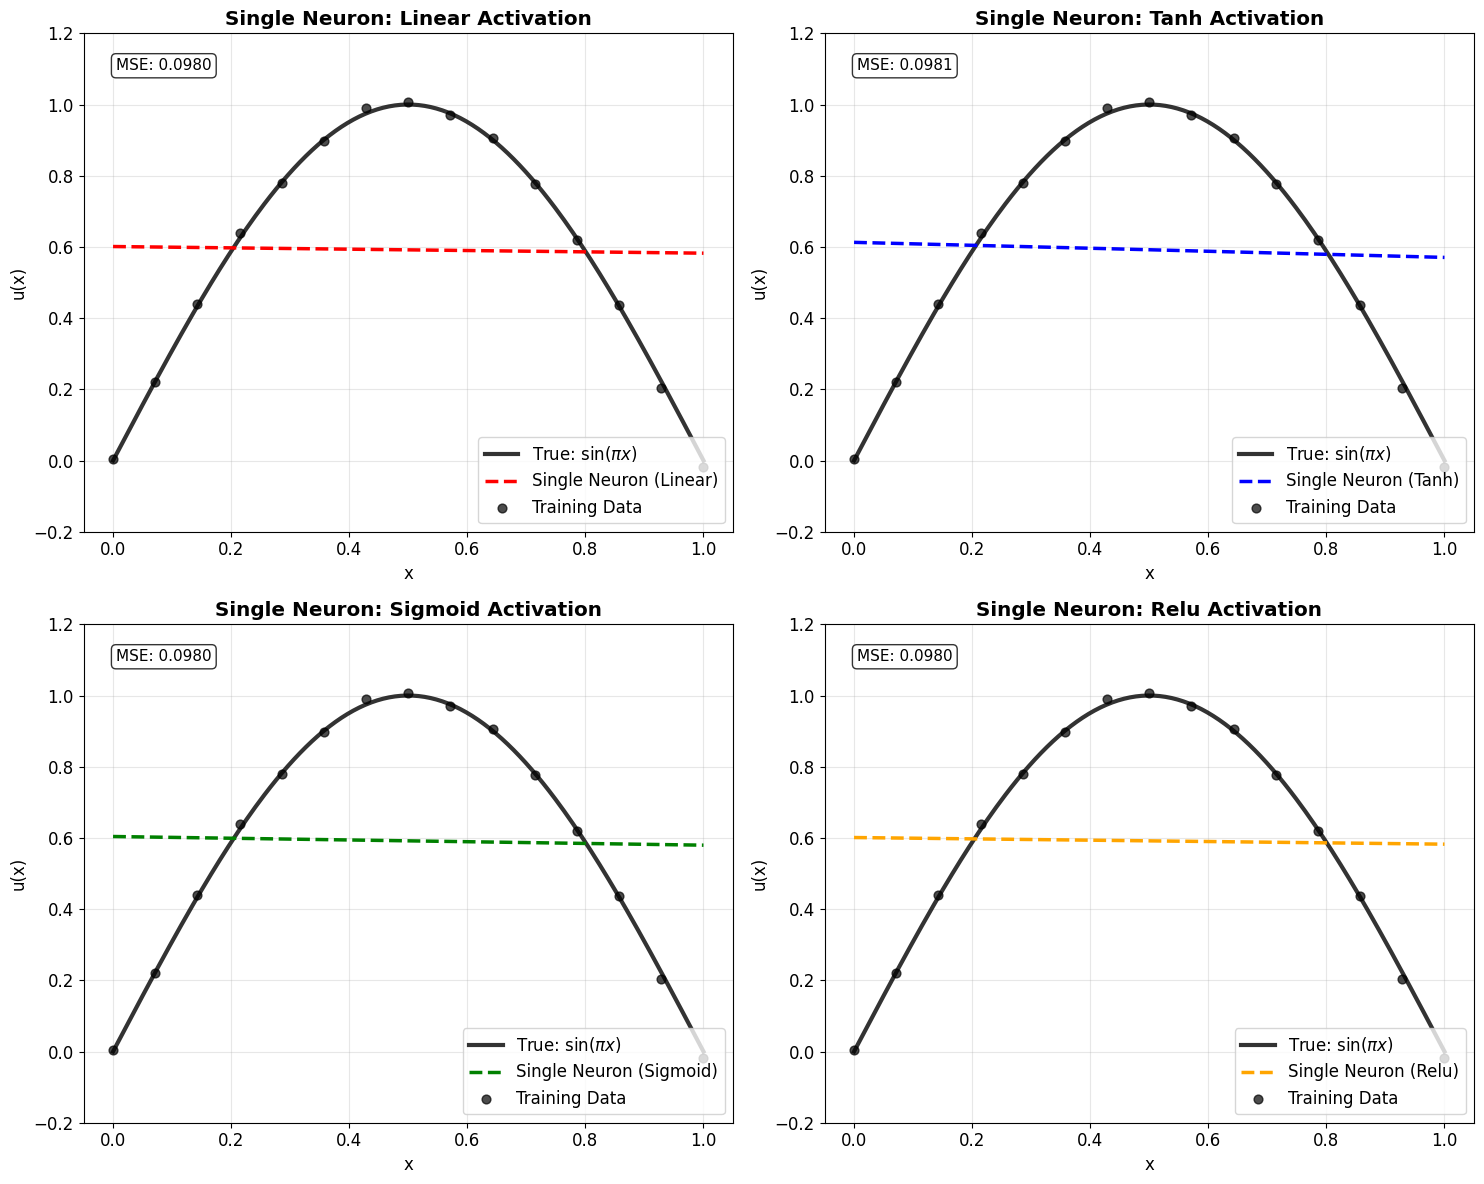


Learned Parameters:
  Linear: w =  -0.019, b =   0.601
    Tanh: w =  -0.065, b =   0.713
 Sigmoid: w =  -0.101, b =   0.422
    Relu: w =  -0.019, b =   0.601


In [3]:
# Visualize single neuron approximations
x_test = np.linspace(0, 1, 200)
x_test_tensor = torch.tensor(x_test.reshape(-1, 1), dtype=torch.float32)
u_true = target_function(x_test)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
axes = [ax1, ax2, ax3, ax4]
colors = ['red', 'blue', 'green', 'orange']

for i, (activation, color) in enumerate(zip(activations, colors)):
    ax = axes[i]
    
    # Get model predictions
    with torch.no_grad():
        u_pred = models[activation](x_test_tensor).numpy().flatten()
    
    # Plot true function
    ax.plot(x_test, u_true, 'k-', linewidth=3, label='True: $\sin(\pi x)$', alpha=0.8)
    
    # Plot prediction
    ax.plot(x_test, u_pred, color=color, linewidth=2.5, linestyle='--', 
            label=f'Single Neuron ({activation.title()})')
    
    # Plot training data
    ax.scatter(x_train, u_train_noisy, color='black', s=40, alpha=0.7, 
              label='Training Data', zorder=5)
    
    # Calculate and display error
    mse = np.mean((u_pred - u_true)**2)
    ax.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            verticalalignment='top', fontsize=11)
    
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
    ax.set_title(f'Single Neuron: {activation.title()} Activation', fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.2, 1.2)

plt.tight_layout()
plt.show()

# Print parameter analysis
print("\nLearned Parameters:")
for activation in activations:
    model = models[activation]
    weight = model.linear.weight.item()
    bias = model.linear.bias.item()
    print(f"{activation.title():>8}: w = {weight:7.3f}, b = {bias:7.3f}")

## Single Layer with Multiple Neurons

The single neuron clearly struggles to capture the sinusoidal behavior. Let's expand to a single layer with multiple neurons:

$$u_{NN}(x) = \sum_{i=1}^{n} w_i^{(2)} \sigma(w_i^{(1)} x + b_i^{(1)}) + b^{(2)}$$

This architecture can potentially represent more complex functions by combining multiple simple transformations.

In [4]:
class SingleLayerNN(nn.Module):
    """Single hidden layer neural network"""
    
    def __init__(self, hidden_size=10, activation='tanh'):
        super(SingleLayerNN, self).__init__()
        self.hidden = nn.Linear(1, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'relu':
            self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

# Train networks with varying hidden layer sizes
hidden_sizes = [5, 10, 20, 50]
activation = 'tanh'  # Best performing from single neuron experiment

single_layer_models = {}
single_layer_losses = {}

for hidden_size in hidden_sizes:
    print(f"\nTraining single layer network with {hidden_size} neurons...")
    model = SingleLayerNN(hidden_size, activation)
    losses = train_network(model, x_train_tensor, u_train_tensor, 
                          epochs=8000, lr=0.01, verbose=False)
    single_layer_models[hidden_size] = model
    single_layer_losses[hidden_size] = losses
    print(f"Final loss: {losses[-1]:.6f}")


Training single layer network with 5 neurons...
Final loss: 0.000047

Training single layer network with 10 neurons...
Final loss: 0.000047

Training single layer network with 20 neurons...
Final loss: 0.000042

Training single layer network with 50 neurons...
Final loss: 0.000042


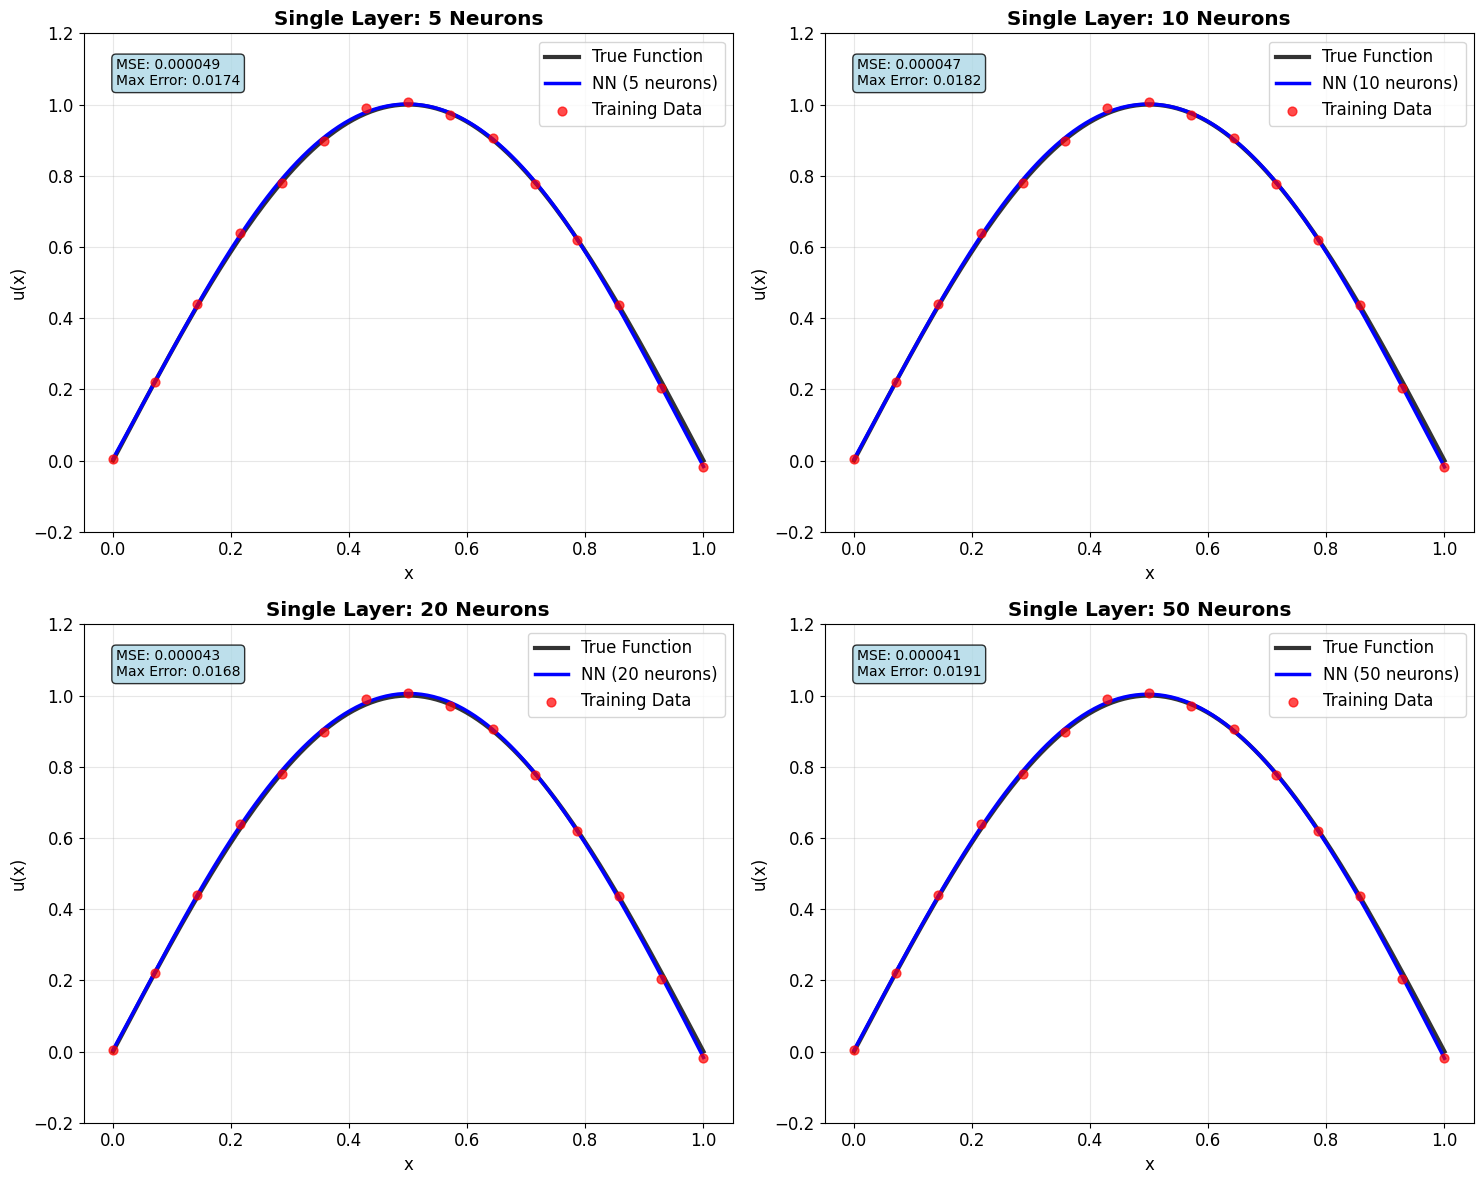

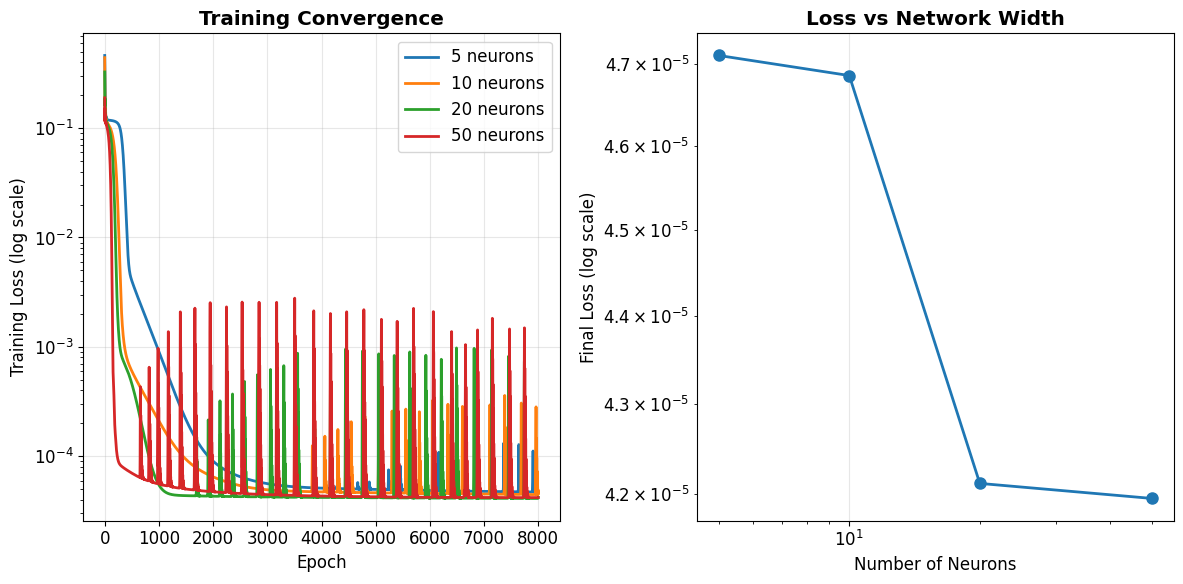


Final Loss Summary:
 5 neurons: 0.00004710
10 neurons: 0.00004685
20 neurons: 0.00004212
50 neurons: 0.00004195


In [5]:
# Visualize the effect of hidden layer size
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
axes = [ax1, ax2, ax3, ax4]

for i, hidden_size in enumerate(hidden_sizes):
    ax = axes[i]
    
    # Get predictions
    with torch.no_grad():
        u_pred = single_layer_models[hidden_size](x_test_tensor).numpy().flatten()
    
    # Plot
    ax.plot(x_test, u_true, 'k-', linewidth=3, label='True Function', alpha=0.8)
    ax.plot(x_test, u_pred, 'b-', linewidth=2.5, 
            label=f'NN ({hidden_size} neurons)')
    ax.scatter(x_train, u_train_noisy, color='red', s=40, alpha=0.7, 
              label='Training Data', zorder=5)
    
    # Calculate error
    mse = np.mean((u_pred - u_true)**2)
    max_error = np.max(np.abs(u_pred - u_true))
    
    ax.text(0.05, 0.95, f'MSE: {mse:.6f}\nMax Error: {max_error:.4f}', 
            transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
            verticalalignment='top', fontsize=10)
    
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
    ax.set_title(f'Single Layer: {hidden_size} Neurons', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.2, 1.2)

plt.tight_layout()
plt.show()

# Plot training convergence
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for hidden_size in hidden_sizes:
    losses = single_layer_losses[hidden_size]
    plt.semilogy(losses, label=f'{hidden_size} neurons', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Training Loss (log scale)')
plt.title('Training Convergence', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
final_losses = [single_layer_losses[h][-1] for h in hidden_sizes]
plt.loglog(hidden_sizes, final_losses, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Neurons')
plt.ylabel('Final Loss (log scale)')
plt.title('Loss vs Network Width', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal Loss Summary:")
for hidden_size in hidden_sizes:
    loss = single_layer_losses[hidden_size][-1]
    print(f"{hidden_size:2d} neurons: {loss:.8f}")

## Analysis of Results

Our experiments reveal several crucial insights:

### 1. **Single Neuron Limitations**
- **Linear activation**: Cannot capture any nonlinearity
- **Nonlinear activations**: Can only represent simple curved functions
- **Fundamental constraint**: One neuron = one "feature" or "basis function"

### 2. **Width Benefits**
- **More neurons = more flexibility**: Additional neurons provide more basis functions
- **Diminishing returns**: Beyond a certain width, improvements become marginal
- **Approximation quality**: Even with 50 neurons, some residual error remains

### 3. **Training Dynamics**
- **Convergence speed**: Wider networks often converge faster initially
- **Optimization landscape**: More parameters can lead to better local minima
- **Overfitting risk**: Very wide networks may memorize training data

Let's examine these insights more deeply:

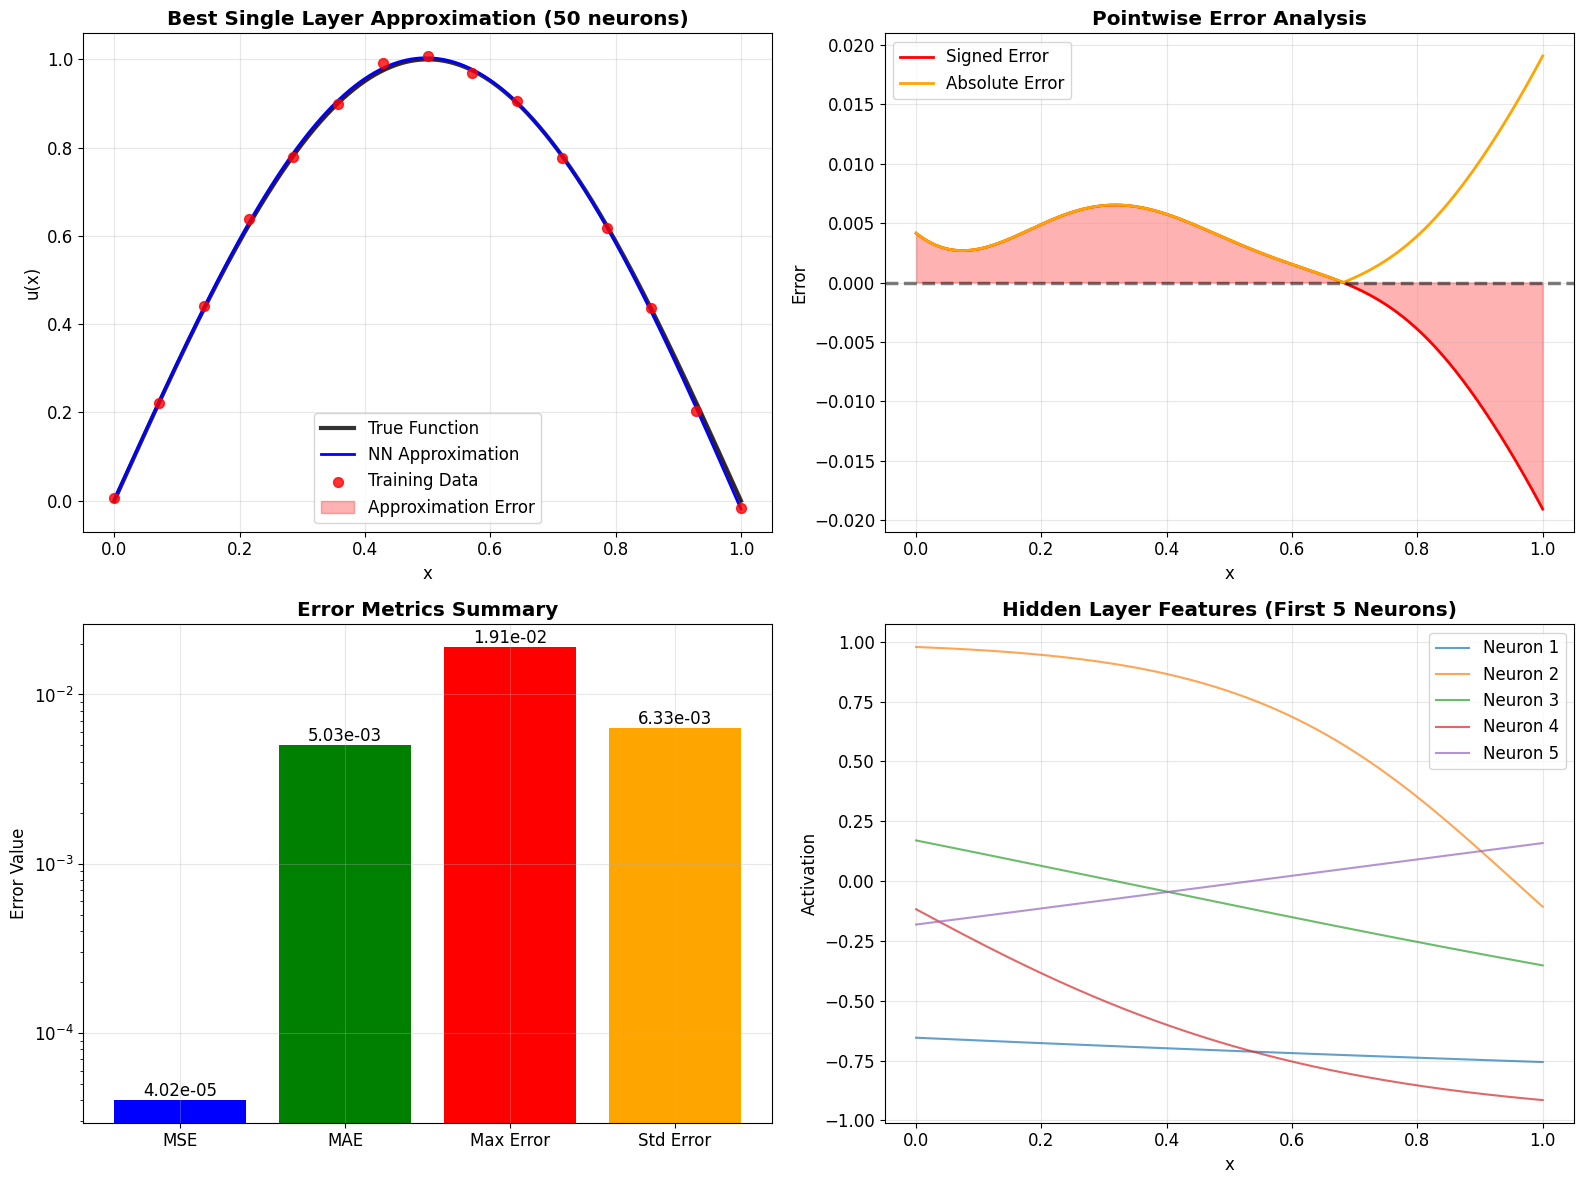


Detailed Error Analysis:
         MSE: 4.015137e-05
         MAE: 5.026977e-03
   Max Error: 1.907974e-02
   Std Error: 6.327224e-03

Error Statistics:
Mean error: 3.429367e-04
Error range: [-1.907974e-02, 6.531620e-03]


In [6]:
# Detailed analysis: Error distribution and feature visualization
best_model = single_layer_models[50]  # Best performing model

# Generate dense test set for error analysis
x_dense = np.linspace(0, 1, 1000)
x_dense_tensor = torch.tensor(x_dense.reshape(-1, 1), dtype=torch.float32)
u_true_dense = target_function(x_dense)

with torch.no_grad():
    u_pred_dense = best_model(x_dense_tensor).numpy().flatten()

# Calculate pointwise error
error = u_pred_dense - u_true_dense
abs_error = np.abs(error)

# Create comprehensive analysis plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Function and approximation
ax1.plot(x_dense, u_true_dense, 'k-', linewidth=3, label='True Function', alpha=0.8)
ax1.plot(x_dense, u_pred_dense, 'b-', linewidth=2, label='NN Approximation')
ax1.scatter(x_train, u_train_noisy, color='red', s=50, alpha=0.8, 
           label='Training Data', zorder=5)
ax1.fill_between(x_dense, u_true_dense, u_pred_dense, alpha=0.3, color='red', 
                label='Approximation Error')
ax1.set_xlabel('x')
ax1.set_ylabel('u(x)')
ax1.set_title('Best Single Layer Approximation (50 neurons)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Error analysis
ax2.plot(x_dense, error, 'r-', linewidth=2, label='Signed Error')
ax2.plot(x_dense, abs_error, 'orange', linewidth=2, label='Absolute Error')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.fill_between(x_dense, 0, error, alpha=0.3, color='red')
ax2.set_xlabel('x')
ax2.set_ylabel('Error')
ax2.set_title('Pointwise Error Analysis', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Error statistics
error_metrics = {
    'MSE': np.mean(error**2),
    'MAE': np.mean(abs_error),
    'Max Error': np.max(abs_error),
    'Std Error': np.std(error)
}

metrics_names = list(error_metrics.keys())
metrics_values = list(error_metrics.values())

bars = ax3.bar(metrics_names, metrics_values, color=['blue', 'green', 'red', 'orange'])
ax3.set_ylabel('Error Value')
ax3.set_title('Error Metrics Summary', fontweight='bold')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.2e}', ha='center', va='bottom')

# Plot 4: Hidden layer features
# Extract and visualize what the hidden neurons learned
with torch.no_grad():
    hidden_output = best_model.activation(best_model.hidden(x_dense_tensor))
    hidden_features = hidden_output.numpy()

# Plot first 5 hidden features
for i in range(min(5, hidden_features.shape[1])):
    ax4.plot(x_dense, hidden_features[:, i], alpha=0.7, linewidth=1.5, 
             label=f'Neuron {i+1}')

ax4.set_xlabel('x')
ax4.set_ylabel('Activation')
ax4.set_title('Hidden Layer Features (First 5 Neurons)', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDetailed Error Analysis:")
for metric, value in error_metrics.items():
    print(f"{metric:>12}: {value:.6e}")

print(f"\nError Statistics:")
print(f"Mean error: {np.mean(error):.6e}")
print(f"Error range: [{np.min(error):.6e}, {np.max(error):.6e}]")

## Key Insights and Implications

This systematic exploration of neural network function approximation reveals fundamental principles:

### **Universal Approximation Intuition**
The improvement with increased width hints at the **Universal Approximation Theorem**: a single hidden layer with sufficient neurons can approximate any continuous function to arbitrary accuracy. However, "sufficient" may require impractically many neurons.

### **The Role of Activation Functions**
Nonlinear activations are essential. Without them, the network reduces to linear regression, regardless of depth or width. The choice of activation function affects:
- **Approximation quality**: Tanh and sigmoid performed better than ReLU for this smooth function
- **Training dynamics**: Different activations have different gradient properties
- **Representation capacity**: Each activation function creates different "basis functions"

### **Width vs. Approximation Quality**
More neurons generally improve approximation, but with diminishing returns. This suggests that width alone may not be the most efficient path to better approximation.

### **Residual Error Patterns**
Even our best single-layer network shows systematic errors. The error is not random—it has structure, suggesting that the network is missing certain aspects of the target function that a single layer cannot capture.

## The Path Forward

Our experiments raise crucial questions:

1. **How wide is "wide enough"?** What determines the minimum width needed for a given approximation accuracy?

2. **Can we do better with depth?** Would multiple layers provide more efficient approximation than width alone?

3. **What about more complex functions?** How do these results extend to functions with higher frequency content or discontinuities?

4. **What theoretical guarantees exist?** Can we predict approximation quality without trial-and-error?

These questions motivate our subsequent investigations into network architecture, universal approximation theory, and the fundamental limitations that drive the need for deeper networks.

## Summary and Preview

In this notebook, we established the practical foundation of neural network function approximation:

1. **Mathematical Framework**: Formulation of function approximation as optimization
2. **Single Neuron Analysis**: Fundamental limitations of minimal architectures
3. **Width Effects**: How additional neurons improve approximation capacity
4. **Activation Function Importance**: The critical role of nonlinearity
5. **Performance Analysis**: Systematic evaluation of approximation quality

**Key Finding**: Single-layer networks can approximate smooth functions reasonably well, but require many neurons and still exhibit systematic errors.

**Next Steps**: Our subsequent notebooks will explore:
- **Width sufficiency**: Theoretical and practical limits of single-layer approximation
- **Nonlinearity deep-dive**: Why activation functions are mathematically necessary
- **Universal approximation**: The theoretical guarantees and their practical implications
- **Failure modes**: Problems that expose single-layer limitations
- **Depth advantages**: How multiple layers overcome these limitations

The journey from function approximation to deep learning continues with deeper theoretical understanding and more challenging problems.